<a href="https://colab.research.google.com/github/mikolaj553/Machine-Learning-Homeworks-Repo/blob/main/ml-hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Homework #2 - Lab group no. 1 - Mikołaj Kowalewski**

Let us start with preparing all the ingredients needed to answer the primary question. We will use the same mouse dataset as in class.

In [32]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

Combined dataset shape: (500, 2)


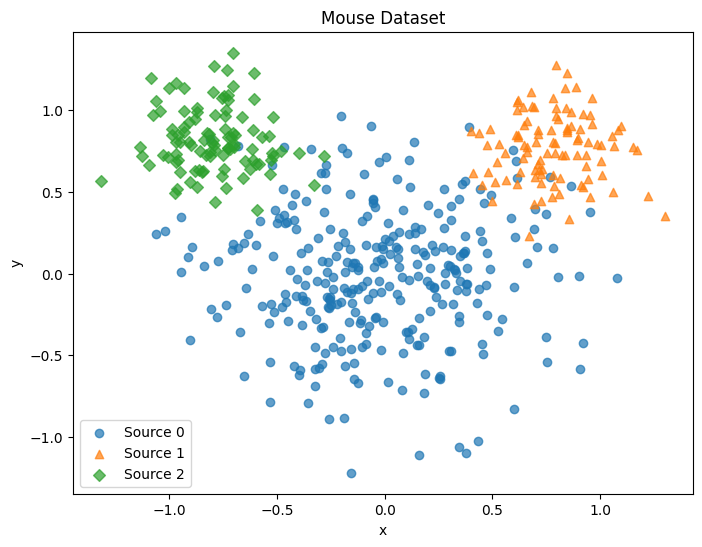

In [33]:
# -----------------------------------------------
# 1) Generating the mouse dataset like in class
# -----------------------------------------------
np.random.seed(0)  # for reproducibility

# 1.1) 300 points from N([0,0], [[0.16,0],[0,0.16]]) (Source 0)
mean0 = np.array([0.0, 0.0])
cov0 = np.array([[0.16, 0.0],
                 [0.0,  0.16]])
data0 = np.random.multivariate_normal(mean0, cov0, 300)

# 1.2) 100 points from N([0.8,0.8], [[0.04,0],[0,0.04]]) (Source 1)
mean1 = np.array([0.8, 0.8])
cov1 = np.array([[0.04, 0.0],
                 [0.0,  0.04]])
data1 = np.random.multivariate_normal(mean1, cov1, 100)

# 1.3) 100 points from N([-0.8,0.8], [[0.04,0],[0,0.04]]) (Source 2)
mean2 = np.array([-0.8, 0.8])
cov2 = np.array([[0.04, 0.0],
                 [0.0,  0.04]])
data2 = np.random.multivariate_normal(mean2, cov2, 100)

# Combine everything
data_X = np.vstack([data0, data1, data2])
N, d = data_X.shape
print(f"Combined dataset shape: {data_X.shape}")

#Visualizing the data
plt.figure(figsize=(8, 6))

# Source 0: circles
plt.scatter(data0[:, 0], data0[:, 1],
            marker='o', color='C0', alpha=0.7,
            label='Source 0')

# Source 1: triangles
plt.scatter(data1[:, 0], data1[:, 1],
            marker='^', color='C1', alpha=0.7,
            label='Source 1')

# Source 2: squares
plt.scatter(data2[:, 0], data2[:, 1],
            marker='D', color='C2', alpha=0.7,
            label='Source 2')

plt.title('Mouse Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')

plt.show()



Number of EM iterations used: 12


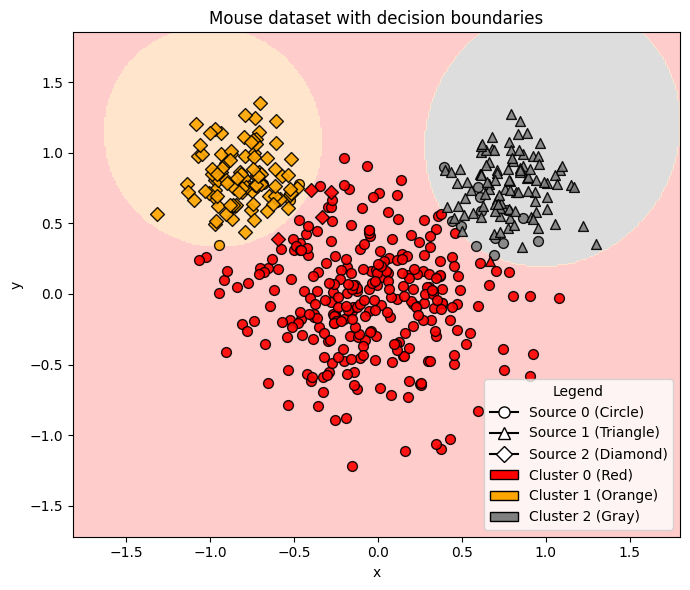

In [34]:
# --------------------------------------------------------
# 2) Fitting a GMM with 3 clusters
# --------------------------------------------------------
K = 3
gmm = GaussianMixture(n_components=K, covariance_type='full', random_state=0)
gmm.fit(data_X)

print("Number of EM iterations used:", gmm.n_iter_)

# --------------------------------------------------------
# 3) Preparing a mesh for decision boundaries
# --------------------------------------------------------
x_min, x_max = data_X[:, 0].min() - 0.5, data_X[:, 0].max() + 0.5
y_min, y_max = data_X[:, 1].min() - 0.5, data_X[:, 1].max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Predicting cluster responsibilities in the grid
resp = gmm.predict_proba(grid_points)
Z = np.argmax(resp, axis=1).reshape(xx.shape)

# --------------------------------------------------------
# 4) Plotting the background (decision boundaries)
#    and the data (markers for sources, colors for clusters) to determine which point went where
# --------------------------------------------------------
plt.figure(figsize=(7, 6))
plt.contourf(
    xx, yy, Z,
    levels=np.arange(K+1) - 0.5,
    colors=["#ffcccc", "#ffe5cc", "#dddddd"],
    alpha=1.0
)

# Markers for each source (0,1,2), colors for each cluster (0,1,2)
source_markers = ['o', '^', 'D']   # circle, triangle, diamond
cluster_colors = ['red', 'orange', 'gray']

sources = [data0, data1, data2]

for s_idx, s_data in enumerate(sources):
    pred_clusters = gmm.predict(s_data)
    for c_idx in range(K):
        subset = s_data[pred_clusters == c_idx]
        plt.scatter(
            subset[:, 0],
            subset[:, 1],
            marker=source_markers[s_idx],
            color=cluster_colors[c_idx],
            edgecolor='k',
            s=50,
            alpha=0.9
        )

# Construct the legend
legend_sources = [
    Line2D([0], [0], marker='o', color='black', label='Source 0 (Circle)',
           markerfacecolor='white', markersize=8),
    Line2D([0], [0], marker='^', color='black', label='Source 1 (Triangle)',
           markerfacecolor='white', markersize=8),
    Line2D([0], [0], marker='D', color='black', label='Source 2 (Diamond)',
           markerfacecolor='white', markersize=8)
]

legend_clusters = [
    Patch(facecolor='red',    edgecolor='black', label='Cluster 0 (Red)'),
    Patch(facecolor='orange', edgecolor='black', label='Cluster 1 (Orange)'),
    Patch(facecolor='gray',   edgecolor='black', label='Cluster 2 (Gray)')
]

all_legend_items = legend_sources + legend_clusters
plt.legend(handles=all_legend_items, loc='best', title='Legend')

plt.title('Mouse dataset with decision boundaries')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()


**Primary Question:**
How can we visualize the decision boundary for attributing a new (unlabeled) point to one of the GMM clusters?

**Answer:** The above plot shows exactly where a new point would fall if it were added to the dataset. For any location in the 2D plane it is possible to see which cluster it belongs to by examining the color of the background, with red corresponding to cluster 0, orange to cluster 1, and gray to cluster 2. This coloring is generated by first building a dense grid of
(x,y) coordinates across the observed data range, then using the GMM to calculate the posterior probabilities of each of the three clusters at every grid coordinate. Each point on this grid is colored according to the cluster with the highest posterior probability. As a result, the boundaries between these colored regions are precisely where two clusters have equal responsibility. Any new point placed in one of these regions will be assigned to the corresponding cluster in that color. Let us now move on to the irregularities in the clustering. We will first assess where points from the original sources were assigned during the clustering procedure.



In [22]:
sources = [data0, data1, data2]
source_names = ["Source 0", "Source 1", "Source 2"]

for i, (src_data, name) in enumerate(zip(sources, source_names)):
    cluster_labels = gmm.predict(src_data)
    # Counting how many points ended up in each cluster
    counts = np.bincount(cluster_labels, minlength=K)

    print(f"{name}:")
    for cluster_id in range(K):
        print(f"  Cluster {cluster_id}: {counts[cluster_id]} points")
    print()

Source 0:
  Cluster 0: 282 points
  Cluster 1: 5 points
  Cluster 2: 13 points

Source 1:
  Cluster 0: 1 points
  Cluster 1: 0 points
  Cluster 2: 99 points

Source 2:
  Cluster 0: 4 points
  Cluster 1: 96 points
  Cluster 2: 0 points



Overall, the GMM did partition the data into three clusters that roughly correspond to the original sources, but the decision boundaries are not perfectly clean. There are regions in the plane where points from different sources are intermingled and the model struggles to decide which cluster they belong to. The most prominent overlaps occur between the central “body” cluster and each “ear” cluster. The central Gaussian’s wide spread caused its region to intertwine with spaces of the smaller Gaussians, yielding curved boundaries and a small number of misclassifications at the edges, especially in the region between the central cluster and the upper-left cluster. These errors are a direct consequence of the shape and density differences: we have a high-variance, high-weight cluster next to a low-variance cluster. From a clustering standpoint, this means the “mistakes” happen in intuitive places (points on the fringes of a cluster).

Let us now move on to the secondary question.


K= 2 => Silhouette Score: 0.4036, Inertia: 187.34
K= 3 => Silhouette Score: 0.4650, Inertia: 99.16
K= 4 => Silhouette Score: 0.4161, Inertia: 73.35
K= 5 => Silhouette Score: 0.4193, Inertia: 55.10
K= 6 => Silhouette Score: 0.4079, Inertia: 50.81
K= 7 => Silhouette Score: 0.4161, Inertia: 41.44
K= 8 => Silhouette Score: 0.3404, Inertia: 39.29
K= 9 => Silhouette Score: 0.3464, Inertia: 35.18
K=10 => Silhouette Score: 0.3332, Inertia: 33.47


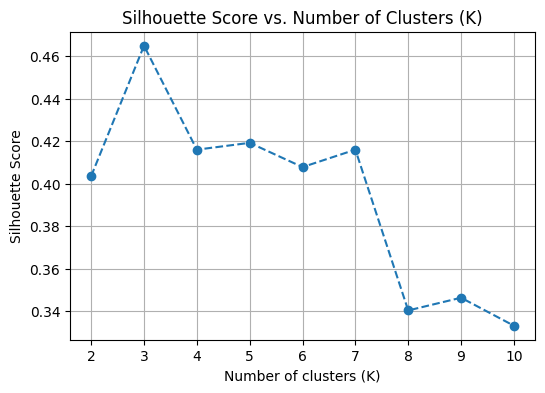

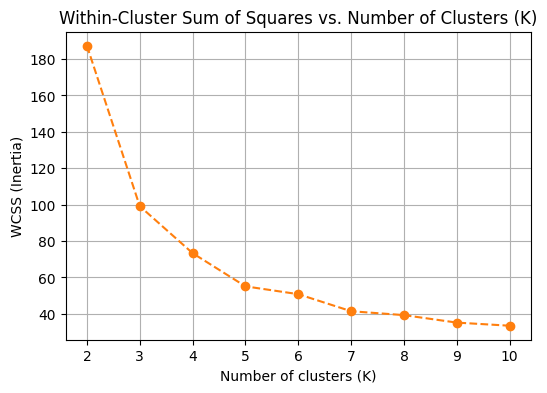

In [31]:
# -----------------------------------------------
# 1) Evaluating GMM for K=2..10
#    -> Computing Silhouette Score & Inertia to measure the quality of the clustering
# -----------------------------------------------
range_K = range(2, 11)
silhouette_scores = []
inertia_values = []

for k in range_K:
    gmm = GaussianMixture(n_components=k, random_state=0)
    labels = gmm.fit_predict(data_X)

    # Silhouette Score (the higher, the better the separation)
    sil_score = silhouette_score(data_X, labels)
    silhouette_scores.append(sil_score)

    # Inertia (Within-Cluster Sum of Squares)
    # We compute WCSS by summing squared distances of each point
    # to the mean of its assigned Gaussian
    means = gmm.means_
    wcss = 0.0
    for i, label in enumerate(labels):
        wcss += np.linalg.norm(data_X[i] - means[label])**2
    inertia_values.append(wcss)

    print(f"K={k:2d} => Silhouette Score: {sil_score:.4f}, Inertia: {wcss:.2f}")

# -----------------------------------------------
# 3) Plotting Silhouette Score vs. no. of clusters K
# -----------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot(list(range_K), silhouette_scores, 'o--', color='C0')
plt.title('Silhouette Score vs. Number of Clusters (K)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# -----------------------------------------------
# 4) Plotting Inertia vs.  no. of clusters K
# -----------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot(list(range_K), inertia_values, 'o--', color='C1')
plt.title('Within-Cluster Sum of Squares vs. Number of Clusters (K)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()

**Secondary Question:** If we didn't know the number of clusters in advance, how could we decide on a suitable for the clustering algorithm?

 **Answer:** If we did not know the number of clusters from the outset, a good way of finding the optimal value of K is using clustering performance metrics such as silhouette score or inertia. In our case, the silhouette score indicates that K = 3 clusters is the best choice (since it assumes the highest value for this K). As for the inertia metric, there is a sharp drop-off between K = 2 and K = 3 and milder drops between K = 3, 4, and K = 4, 5. For K > 5, the inertia still decreases, albeit at a much slower rate. Incorporating this many clusters would lead to a loss of simplicity to a model without much gain in terms of the quality of the clustering (according to the silhouette score, the quality thereof would actually deteriorate). Therefore, based on these two metrics, K = 3 is the optimal choice - providing the best trade-off between proper separation of the data and low within-cluster variance (indicated by the SS metric and the WCSS metric, respectively). This aligns with the structure of the mouse dataset.